<a href="https://www.kaggle.com/code/kavishchaudhary1003/phone-price-classifcation-multiple-models?scriptVersionId=120398039" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, IsolationForest, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [51]:
train = pd.read_csv('/kaggle/input/mobile-price-classification/train.csv')
test = pd.read_csv('/kaggle/input/mobile-price-classification/test.csv')

#### Setting id as index for the test 


In [52]:
test = test.set_index('id')

#### Printing the value counts for the train set

In [53]:
for i in train.columns:
    print(train[i].value_counts())

1872    6
618     6
1589    6
1715    5
1807    5
       ..
660     1
1452    1
1005    1
1372    1
858     1
Name: battery_power, Length: 1094, dtype: int64
0    1010
1     990
Name: blue, dtype: int64
0.5    413
2.8     85
2.3     78
2.1     76
1.6     76
2.5     74
0.6     74
1.4     70
1.3     68
1.5     67
2.0     67
1.9     65
0.7     64
2.9     62
1.8     62
1.0     61
1.7     60
2.2     59
0.9     58
2.4     58
0.8     58
1.2     56
2.6     55
2.7     55
1.1     51
3.0     28
Name: clock_speed, dtype: int64
1    1019
0     981
Name: dual_sim, dtype: int64
0     474
1     245
2     189
3     170
5     139
4     133
6     112
7     100
9      78
8      77
10     62
11     51
12     45
13     40
16     24
15     23
14     20
18     11
17      6
19      1
Name: fc, dtype: int64
1    1043
0     957
Name: four_g, dtype: int64
27    47
16    45
14    45
57    42
2     42
      ..
22    24
38    23
62    21
4     20
59    18
Name: int_memory, Length: 63, dtype: int64
0.1    320
0.2    

#### Checking for null and duplicated values

In [54]:
train.isna().sum()
train.duplicated().sum()

0

#### Summary stats for train set


In [55]:
train[['battery_power', 'clock_speed', 'fc','int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height','px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']].describe()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,1.522250,4.309500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000
std,439.418206,0.816004,4.341444,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955
min,501.000000,0.500000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000
25%,851.750000,0.700000,1.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000
50%,1226.000000,1.500000,3.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000
75%,1615.250000,2.200000,7.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000
max,1998.000000,3.000000,19.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000


#### Co relation map for the variables

In [56]:
corr = train.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
battery_power,1.000000,0.011252,0.011482,-0.041847,0.033334,0.015665,-0.004004,0.034085,0.001844,-0.029727,0.031441,0.014901,-0.008402,-0.000653,-0.029959,-0.021421,0.052510,0.011522,-0.010516,-0.008343,0.200723
blue,0.011252,1.000000,0.021419,0.035198,0.003593,0.013443,0.041177,0.004049,-0.008605,0.036161,-0.009952,-0.006872,-0.041533,0.026351,-0.002952,0.000613,0.013934,-0.030236,0.010061,-0.021863,0.020573
clock_speed,0.011482,0.021419,1.000000,-0.001315,-0.000434,-0.043073,0.006545,-0.014364,0.012350,-0.005724,-0.005245,-0.014523,-0.009476,0.003443,-0.029078,-0.007378,-0.011432,-0.046433,0.019756,-0.024471,-0.006606
dual_sim,-0.041847,0.035198,-0.001315,1.000000,-0.029123,0.003187,-0.015679,-0.022142,-0.008979,-0.024658,-0.017143,-0.020875,0.014291,0.041072,-0.011949,-0.016666,-0.039404,-0.014008,-0.017117,0.022740,0.017444
fc,0.033334,0.003593,-0.000434,-0.029123,1.000000,-0.016560,-0.029133,-0.001791,0.023618,-0.013356,0.644595,-0.009990,-0.005176,0.015099,-0.011014,-0.012373,-0.006829,0.001793,-0.014828,0.020085,0.021998
four_g,0.015665,0.013443,-0.043073,0.003187,-0.016560,1.000000,0.008690,-0.001823,-0.016537,-0.029706,-0.005598,-0.019236,0.007448,0.007313,0.027166,0.037005,-0.046628,0.584246,0.016758,-0.017620,0.014772
int_memory,-0.004004,0.041177,0.006545,-0.015679,-0.029133,0.008690,1.000000,0.006886,-0.034214,-0.028310,-0.033273,0.010441,-0.008335,0.032813,0.037771,0.011731,-0.002790,-0.009366,-0.026999,0.006993,0.044435
m_dep,0.034085,0.004049,-0.014364,-0.022142,-0.001791,-0.001823,0.006886,1.000000,0.021756,-0.003504,0.026282,0.025263,0.023566,-0.009434,-0.025348,-0.018388,0.017003,-0.012065,-0.002638,-0.028353,0.000853
mobile_wt,0.001844,-0.008605,0.012350,-0.008979,0.023618,-0.016537,-0.034214,0.021756,1.000000,-0.018989,0.018844,0.000939,0.000090,-0.002581,-0.033855,-0.020761,0.006209,0.001551,-0.014368,-0.000409,-0.030302
n_cores,-0.029727,0.036161,-0.005724,-0.024658,-0.013356,-0.029706,-0.028310,-0.003504,-0.018989,1.000000,-0.001193,-0.006872,0.024480,0.004868,-0.000315,0.025826,0.013148,-0.014733,0.023774,-0.009964,0.004399


#### Separating the predictors and traget variable

In [57]:
y = train.price_range
train.drop(columns = ['price_range'], inplace = True)


#### Checking the distribution of the target variable


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price_range', ylabel='count'>

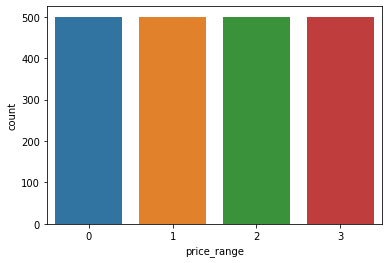

In [58]:
sns.countplot(y)


#### Checking the distribution of categorical variables

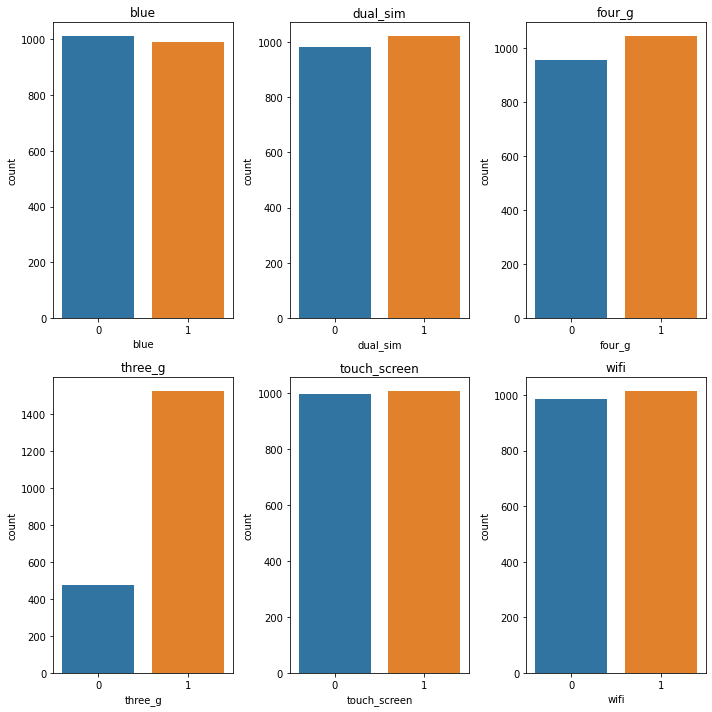

In [59]:
fig, axes = plt.subplots(nrows=2, ncols = 3, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    if i< len(['blue', 'dual_sim', 'four_g', 'three_g',
       'touch_screen', 'wifi']):
        sns.countplot(x= train[(['blue', 'dual_sim', 'four_g', 'three_g',
       'touch_screen', 'wifi'][i])], ax= ax)
        ax.set_title(['blue', 'dual_sim', 'four_g', 'three_g',
       'touch_screen', 'wifi'][i])
plt.tight_layout()
plt.show()


#### Histogram for the continuous variables to observe the distribution

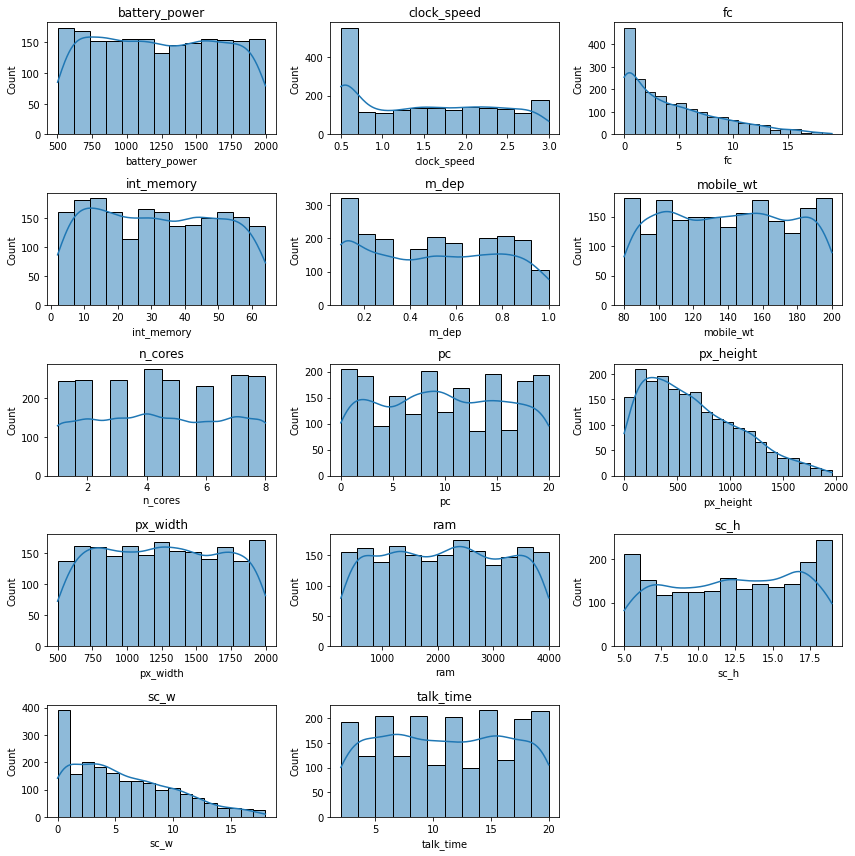

In [60]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    if i < len(['battery_power', 'clock_speed', 'fc',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']):
        sns.histplot(train[(['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'][i])], kde=True, ax=ax)
        ax.set_title(['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()


#### Boxplot to check for the outliers

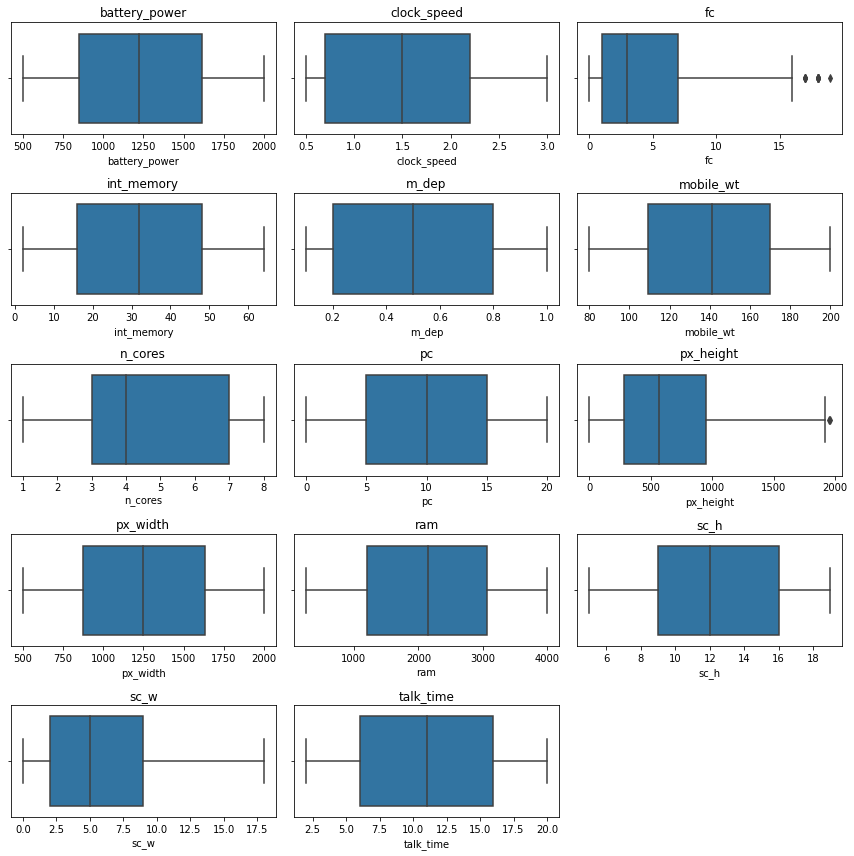

In [61]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (12,12))
for i, ax in enumerate(axes.flat):
    if i < len(['battery_power', 'clock_speed', 'fc',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']):
        sns.boxplot(x= train[(['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'][i])], ax=ax)
        ax.set_title(['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()


#### Defining a function model_eval which uses RandomizedSearchCV for parameter tuning 
* Nested cross val used for training and testing to reduce the bias.
* tqdm used to display a progress bar when performing parameter tuning.
* Storing the score during each iteration and printing the mean score. 

In [62]:
def model_eval(model, param, train, y):
    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
    random = RandomizedSearchCV(model, param, scoring = 'accuracy', n_jobs = -1, cv = inner_cv, random_state = 0)
    scores = []
    n_iter = random.n_iter
    with tqdm(total = n_iter) as pbar:
        for i in range(n_iter):
            random.set_params(n_iter = 1)
            for train_index, test_index in outer_cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                random.fit(trainx, trainy)
                scores.append(random.best_estimator_.score(testx, testy))
            pbar.update()
    print(random.best_params_)
    print('Average score', np.mean(scores))
    

### Decision Tree used for predictions
Mean accuracy of 82.4% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier

In [63]:
model = DecisionTreeClassifier()
min_samples_split = np.array(range(1, 100))
max_depth= np.array(range(1,100))
criterion = ['entropy', 'gini', 'log_loss']
param = {'min_samples_split': min_samples_split, 'max_depth' : max_depth, 'criterion' : criterion}
model_eval(model, param, train, y)

100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

{'min_samples_split': 60, 'max_depth': 28, 'criterion': 'entropy'}
Average score 0.8240000000000001


### Random Forest used for predictions
Mean accuracy of 84.9% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier
* n_estimators- no. of trees in the forest

In [64]:
model = RandomForestClassifier()
min_samples_split = np.array(range(1, 100))
max_depth = np.array(range(1, 100))
criterion = ['gini', 'entropy']
n_estimators = np.array(range(100, 400, 5))
param = {'min_samples_split': min_samples_split, 'max_depth': max_depth, 'criterion': criterion, 'n_estimators': n_estimators}
model_eval(model, param, train, y)

100%|██████████| 10/10 [01:05<00:00,  6.54s/it]

{'n_estimators': 155, 'min_samples_split': 47, 'max_depth': 52, 'criterion': 'gini'}
Average score 0.8521000000000001


### Extra Trees used for predictions
Mean accuracy of 84.6% was obtained on the test set.

Parameters tuned :
* min_samples_split- min no. of samples required tosplit the node
* max_depth- max depth of a tree
* criterion- gini, entropy and log_loss are the three options available for classifier
* n_estimators- no. of trees in the forest

In [65]:
model = ExtraTreesClassifier()
criterion = ['gini', 'entropy']
max_depth = np.array(range(50, 150))
min_samples_split = np.array(range(1, 100))
n_estimators = np.array(range(100,300, 2))
param = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'n_estimators': n_estimators}
model_eval(model, param, train, y)

100%|██████████| 10/10 [00:33<00:00,  3.32s/it]

{'n_estimators': 122, 'min_samples_split': 88, 'max_depth': 80, 'criterion': 'gini'}
Average score 0.8464999999999999


### GaussianNB used for prediction
Mean accuracy of 80.2% obtained in the test set.

Parameters tuned:
* var_smoothing- Adds a value to the variance of the distribution of the train set

In [66]:
model = GaussianNB()
param = {'var_smoothing': np.logspace(0,-9, num=100)}
model_eval(model, param, train, y)

100%|██████████| 10/10 [00:02<00:00,  4.95it/s]

{'var_smoothing': 0.0001}
Average score 0.8019999999999999


### SVC used for prediction
Mean accuracy of 97.1% obtained in the test set.

Parameters tuned:
* C- Regularization parameter. The strength of the regularization is inversely propotional to C
* gamma- control the shape of the decision boundary.Larger value implies overfitting.
* kernel- poly, linear and rbf are selected  


In [67]:
model = SVC()
param = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100],'kernel': ['rbf', 'poly', 'linear'] }
model_eval(model, param, train,y)

100%|██████████| 10/10 [04:10<00:00, 25.03s/it]

{'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}
Average score 0.9704999999999999


### Bagging Classifier used for prediction
Mean accuracy of 83.2% obtained in the test set.

Parameters tuned:
* n_estimators- no. of estimators
* max_features- max no. of features 

In [68]:
model = BaggingClassifier()
n_estimators = np.array(range(100,300,2))
max_features = np.array(range(1,20))
param = {'n_estimators': n_estimators, 'max_features': max_features}
model_eval(model, param, train, y)

100%|██████████| 10/10 [03:20<00:00, 20.03s/it]

{'n_estimators': 268, 'max_features': 7}
Average score 0.8299


### XGBoost used for prediction
Mean accuracy of 90.1% obtained in the test set.


In [69]:
model = XGBClassifier(objective='multi:softmax',
                     eval_metric='mlogloss', num_class = 4)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                scores.append(model.score(testx, testy))
print('Average score', np.mean(scores))


Average score 0.9075


### LGBM Boost used for prediction
Mean accuracy of 90.1% obtained in the test set.

Parameters tuned:
* leatning_rate- learning rate of the model
* max_depth- max_depth of the tree
* alpha- l1 regularization
* reg_lambda- l2 regularization
* colsample_bytree- subsample ratio of columns when constructing each tree
* subsample- subsample ratio
* subsample_freq- frequency of the subsample
* min_child_samples- min no. of data needed in a child(leaf)
* n_estimators- no. of trees
* num_leaves- max tree leaves

In [70]:
model = LGBMClassifier()
learning_rate = np.linspace(0.01, 0.2, 10)
max_depth = np.array(range(1, 10))
alpha= np.array(range(0, 50))
reg_lambda = np.linspace(0, 100, 10)
colsample_bytree = np.linspace(0.1,1, 10)
subsample = np.linspace(0.1, 1, 10)
subsample_freq = np.array(range(1, 10, 10))
min_child_samples  = np.array(range(1,50,10))
n_estimators = np.array(range(200, 2000,100 ))
num_leaves =np.array(range(2, 200, 11))
param= {'learning_rate': learning_rate, 'max_depth': max_depth, 'alpha': alpha, 'reg_lambda': reg_lambda, 'colsample_bytree': colsample_bytree,
        'subsample': subsample, 'subsample_freq': subsample_freq, 'min_child_samples': min_child_samples, 'n_estimators': n_estimators,
        'num_leaves': num_leaves}
model_eval(model, param, train, y)

100%|██████████| 10/10 [07:02<00:00, 42.23s/it]

{'subsample_freq': 1, 'subsample': 1.0, 'reg_lambda': 33.33333333333333, 'num_leaves': 68, 'n_estimators': 1800, 'min_child_samples': 21, 'max_depth': 4, 'learning_rate': 0.1366666666666667, 'colsample_bytree': 0.5, 'alpha': 17}
Average score 0.9009999999999998


### Cat Boost used for prediction
Mean accuracy of 93.5% obtained in the test set.

In [71]:
model = CatBoostClassifier(verbose = 0)
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = []
for train_index, test_index in cv.split(train, y):
                trainx, testx = train.iloc[train_index], train.iloc[test_index]
                trainy, testy = y[train_index], y[test_index]
                model.fit(trainx, trainy)
                scores.append(model.score(testx, testy))
print('Average score', np.mean(scores))


Average score 0.9350000000000002
